# Identify sign language using Siamese Network with Triplet Loss

Siamese Networks are a class of neural networks capable of one-shot learning. It is usually used in face recognition application to recognise similar faces. In this exercise, I applied the concept to the MNIST sign language to recognise similar hand signals. I set up a Siamese Network with three identical subnets. Then I provide three images to the model via the 3 subnet, where two of them will be similar (anchor and positive images), and the third will be unrelated (a negative example.) The model will then be trained to learn to estimate the similarity and non-similarity between images using the Triplet Loss function.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## Data Preparation

The data given is in the form of CSV. I read them all into a pandas dataframe and do the pre-processing. The first column is the label and the rest of the remaining columns are the information that makes up the hand sign images. Each images are in the shape of (28, 28, 1).

In [2]:
train_data = pd.read_csv('./data/sign_mnist_train.csv')
test_data = pd.read_csv('./data/sign_mnist_test.csv')

In [3]:
print(train_data.shape, test_data.shape)
y_train = train_data['label']
y_test = test_data['label']
train_data.drop('label', axis = 1, inplace = True)
test_data.drop('label', axis = 1, inplace = True)
print(train_data.shape, test_data.shape)

(27455, 785) (7172, 785)
(27455, 784) (7172, 784)


In [4]:
label_range = sorted(y_train.unique())
print("label range values: {}".format(label_range))

label range values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [5]:
x_train = train_data.values.reshape(train_data.shape[0],28,28,1)
x_test = test_data.values.reshape(test_data.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

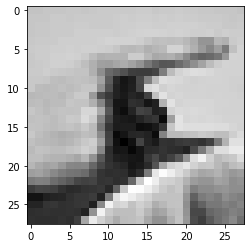

In [6]:
plt.imshow(x_test[0].reshape(28,28), cmap='gray')

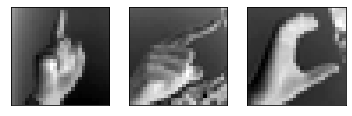

In [7]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()

plot_triplets([x_train[0], x_train[1], x_train[2]])

## Data batching logic

The logic here in creating each training batch is:
* Depends on the flag 'test', the corresponding train/test images will be used
* Pick a random row (using a random number) from the data array. Get the label (y1) and the data (x1) from the row location given by then random number
* Identify all the similar data from the rest of the data array where the labels are equal to y1. These are the candidate data for the positive images 
* Likewise, identify all the non-similar data from the rest of the data array where the labels are not equal to y1. These are the candidate data for the negative images. 
* Randomly pick 1 sample positive images list data (x_positive) and 1 sample from the negative images list (x_negative)
* Return the data triplat of [anchor image, positive image, negative image]


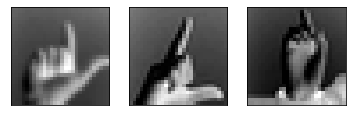

In [8]:
def create_batch(batch_size=256, test=False):
    anchors_list   = []
    positives_list = []
    negatives_list = []

    if test:    
        y = y_test; x = x_test
    else:
        y = y_train; x = x_train
        
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = np.random.randint(0, x.shape[0] - 1)
        x_anchor = x[random_index]
        y_label = y[random_index]
        
        indices_for_pos = np.squeeze(np.where(y == y_label))
        indices_for_neg = np.squeeze(np.where(y != y_label))
        
        x_positive = x[indices_for_pos[np.random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = x[indices_for_neg[np.random.randint(0, len(indices_for_neg) - 1)]]
        
        anchors_list.append(x_anchor)
        positives_list.append(x_positive)
        negatives_list.append(x_negative)

    anchors_list = np.array(anchors_list, dtype='float32')
    positives_list = np.array(positives_list, dtype='float32')
    negatives_list = np.array(negatives_list, dtype='float32')
        
    return [anchors_list, positives_list, negatives_list]

examples = create_batch(1)
plot_triplets(examples)

In [9]:
def data_generator(batch_size=256, test=False):
    while True:
        x = create_batch(batch_size, test)
        y = np.ones(batch_size)
        yield x, y

## Loss Functions

For the network to learn, we use a triplet loss function. The triplet loss function is given by:
>     L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)

In [10]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

## Model Definition

The Siamese Network will generate embeddings for each of the images of the triplet. The image embeddings will be generated by the embedding_model, built using the combination of Convolution layers, MaxPooling layers and Dense layers. The input size will be defined by imsize (28). There will be three embedding networks initialised in parallel.Then the 3 parallel models will be stitched together using a Lambda layer, where the output the distance between the anchor and the positive embedding, as well as the distance between the anchor and the negative embedding will be calculated. I use the Adam optimiser for this network

In [11]:
imsize = 28
batch_size = 32
LR = 0.0001

def embedding_model():
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(label_range)))
    return model

def complete_model(base_model):
    input_1 = Input((imsize, imsize, 1), name="input_1")
    input_2 = Input((imsize, imsize, 1), name="input_2")
    input_3 = Input((imsize, imsize, 1), name="input_3")
        
    loss = Lambda(triplet_loss)([base_model(input_1), base_model(input_2), base_model(input_3)]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    
    return model

2021-10-16 14:41:54.088693: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 24)           602616      input_1[0][0]                    
                                                                 input_2[0][0]                

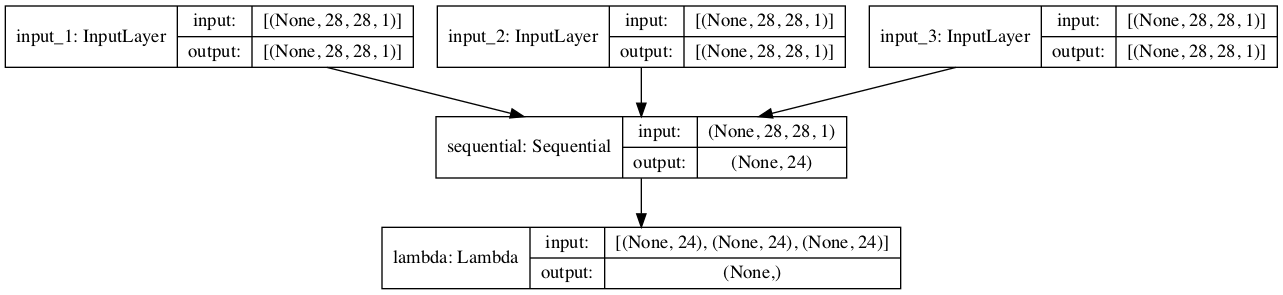

In [12]:
base_model = embedding_model()
model = complete_model(base_model)
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='siamanese_network.png', show_shapes=True, show_layer_names=True)

## Model training

In [13]:
train_generator = data_generator(batch_size)
test_generator = data_generator(batch_size, test=True)

checkpoint_last = ModelCheckpoint('last_weights.h5', 
                                  monitor='val_loss',
                                  save_best_only=True,
                                  save_weights_only = False, 
                                  verbose=1)

steps_per_epoch = int(x_train.shape[0]/batch_size)
validation_steps = int(x_test.shape[0]/batch_size)

history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs = 10,
                    verbose = 1,
                    steps_per_epoch = steps_per_epoch,
                    callbacks=[checkpoint_last],
                    validation_steps = validation_steps)

2021-10-16 14:42:01.694211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
857/857 [==============================] - 60s 69ms/step - loss: 0.1187 - val_loss: 0.0563

Epoch 00001: val_loss improved from inf to 0.05632, saving model to last_weights.h5
Epoch 2/10
857/857 [==============================] - 58s 67ms/step - loss: 0.0432 - val_loss: 0.0345

Epoch 00002: val_loss improved from 0.05632 to 0.03454, saving model to last_weights.h5
Epoch 3/10
857/857 [==============================] - 59s 69ms/step - loss: 0.0264 - val_loss: 0.0245

Epoch 00003: val_loss improved from 0.03454 to 0.02447, saving model to last_weights.h5
Epoch 4/10
857/857 [==============================] - 60s 70ms/step - loss: 0.0203 - val_loss: 0.0199

Epoch 00004: val_loss improved from 0.02447 to 0.01993, saving model to last_weights.h5
Epoch 5/10
857/857 [==============================] - 63s 74ms/step - loss: 0.0159 - val_loss: 0.0170

Epoch 00005: val_loss improved from 0.01993 to 0.01700, saving model to last_weights.h5
Epoch 6/10
857/857 [=============================

## Visualise training and validation losses

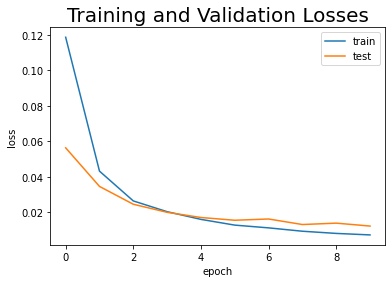

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Visualise Scatter Plot distributions

Here, I visualise the model inference outputs on a scatter plot. Not that while the label range is from (0 - 24), there is a missing label of 9 within. This is compensated by the +1 in this line of code:
> palette = np.array(sns.color_palette("hls", len(label_range)+1))

In [15]:
from sklearn.manifold import TSNE

X_train_trm = base_model.predict(x_train.reshape(-1,28,28,1))
X_test_trm = base_model.predict(x_test.reshape(-1,28,28,1))

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(X_test_trm)

/Users/christopher_sia/opt/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/christopher_sia/opt/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


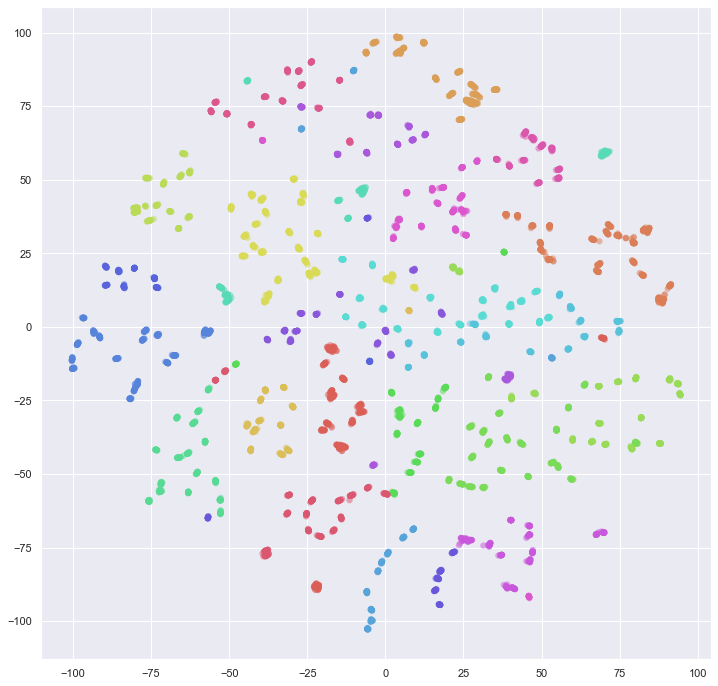

In [17]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd

def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", len(label_range)+1))
    # We create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

scatter(test_tsne_embeds, y_test)

In [18]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((24,))
Classifier_output = Dense(25, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

Classifier_model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,y_train, validation_data=(X_test_trm,y_test),epochs=10)

Epoch 1/10
858/858 [==============================] - 1s 738us/step - loss: 2.4247 - accuracy: 0.6349 - val_loss: 1.9568 - val_accuracy: 0.7554
Epoch 2/10
858/858 [==============================] - 1s 628us/step - loss: 1.4578 - accuracy: 0.9308 - val_loss: 1.3654 - val_accuracy: 0.8298
Epoch 3/10
858/858 [==============================] - 1s 612us/step - loss: 0.9709 - accuracy: 0.9702 - val_loss: 1.0500 - val_accuracy: 0.8451
Epoch 4/10
858/858 [==============================] - 1s 657us/step - loss: 0.6970 - accuracy: 0.9753 - val_loss: 0.8591 - val_accuracy: 0.8638
Epoch 5/10
858/858 [==============================] - 1s 709us/step - loss: 0.5269 - accuracy: 0.9792 - val_loss: 0.7313 - val_accuracy: 0.8678
Epoch 6/10
858/858 [==============================] - 1s 691us/step - loss: 0.4136 - accuracy: 0.9823 - val_loss: 0.6446 - val_accuracy: 0.8685
Epoch 7/10
858/858 [==============================] - 1s 644us/step - loss: 0.3341 - accuracy: 0.9838 - val_loss: 0.5828 - val_accuracy:

## Inference function

The inference of the siamese model happens at 2 levels. The first inference is done by calling the predict function of the base_model. The output is then given to the Classifier model for the second inference. The most probable class is then assessed from the second inference' output.

In [19]:
def infer(x):
    pred_class = []
    temp = base_model.predict(x.reshape(-1, 28, 28, 1))
    temp = Classifier_model.predict(temp)
    temp = np.argmax(temp, axis=-1)
    pred_class = np.append(pred_class, temp)
    
    return pred_class.astype(int)

In [20]:
print("Test inference - inference label: {}, ground truth label: {}".format(infer(x_test[10])[0], y_test[10]))

Test inference - inference label: 8, ground truth label: 8


## Assess overall 

Here, I assess the overall accuracy of the trained model by comparing the inference outputs against the ground truths. And also to generate the confusion matrics using methods from sklearn.metrics.

In [21]:
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(data, labels, output_filename=None):
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(24, 24))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    #plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

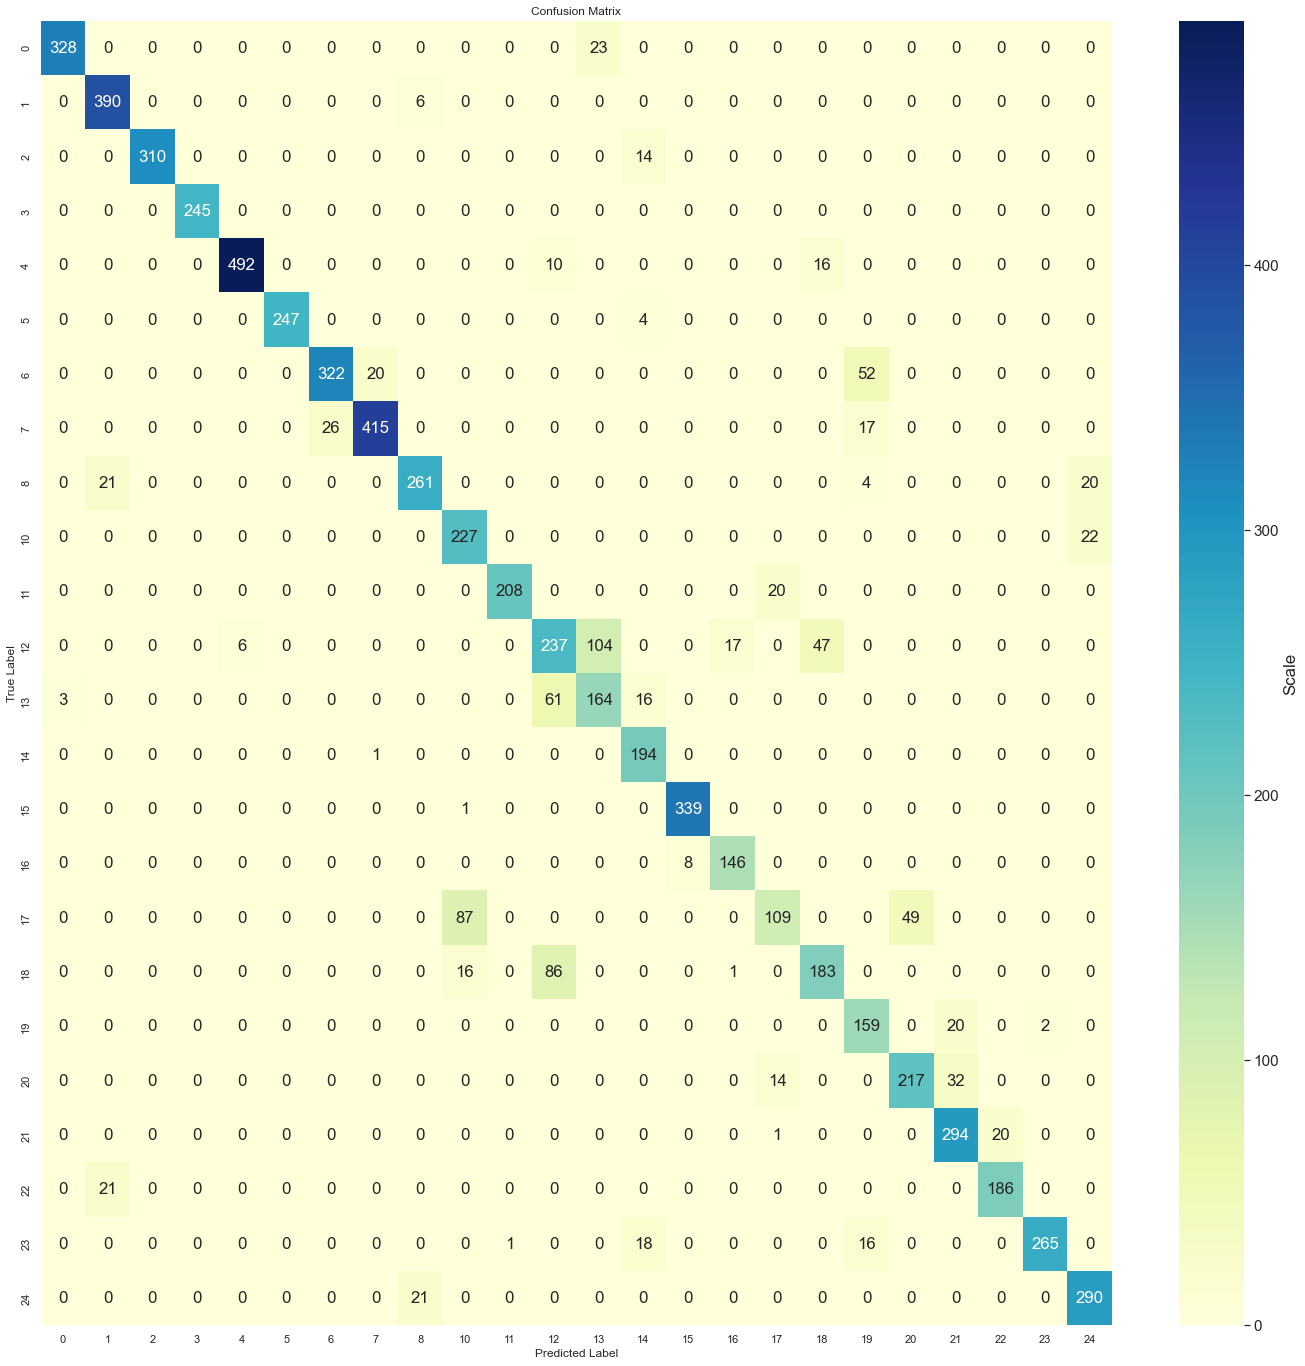

In [22]:
y_pred = infer(x_test)
c_matrix = confusion_matrix(y_pred, y_test)
plot_confusion_matrix(c_matrix, label_range)

In [23]:
print("Overall Accuracy : {}%".format(round(accuracy_score(y_pred, y_test) * 100, 3)))

Overall Accuracy : 86.838%
